The sequences of heatmaps have are lists of 24 objects which report the temperature of the cables as flatteneded matrices of length 15*15. To tackle the first objective I see the sequence data as a 3D matrix and try the classification task using a CNN architecture with a 3D convolutional layer, where the kernel is itself a tridimensional object. In the following, after the imports and other set-ups, I read the data from the input json file and reshape it in order to have a numpy array of 3D matrices.

In [1]:
# Imports
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import ipywidgets as widgets
from IPython.display import display, clear_output
import gc
import dgl
import networkx as nx

In [2]:
# Check if CUDA is available and use it, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Path to dati.json, change this to your file path
json_file_path = 'data.json'

# Open and load the json file
with open(json_file_path, 'r') as file:
    data = json.load(file)

In [4]:
# Extract heatmap sequences, quench_labels information and quenches
sequences = []
quench_labels = []
quenches_list = []

# Loop over the heatmap sequences in the json file
for item in data:
    # Convert the list of heatmaps to a numpy array
    sequence = np.array(item['sequence'])
    seq_length, grid_size_squared = sequence.shape
    grid_size = int(np.sqrt(grid_size_squared))
    # I also define the maximum value for x and y on the grid
    grid_max = grid_size - 1
    # Reshape sequence to (seq_length, grid_size, grid_size)
    sequence = sequence.reshape(seq_length, grid_size, grid_size)
    sequences.append(sequence)
    # Append label
    quench_labels.append(item['label'])
    # Append quenches if they exist
    if 'quench' in item:
        # Plotting the heatmaps in the following steps I realized that the x and y coordinates are inverted
        quenches = [[q['step'], q['pixel'][1], q['pixel'][0], q['temp']] for q in item['quench']]
    else:
        quenches = []
    quenches_list.append(quenches)

# Convert sequences and quench_labels to numpy arrays
sequences = np.array(sequences)
quench_labels = np.array(quench_labels)
# Print the shape of the obtained objects
print(f'Sequences shape: {sequences.shape}')
print(f'Quench labels shape: {quench_labels.shape}')
print(f'Quenches list length: {len(quenches_list)}')


Sequences shape: (3000, 24, 15, 15)
Quench labels shape: (3000,)
Quenches list length: 3000


Since the problem is symmetric under rotation of multiples of $\frac{\pi}{2}$, I can add to the dataset the starting inputs rotated by 90°, 180° and 270°. I can also exploit the symmetry for horizontal and vertical flipping as well as flipping with respect to both diagonals, so that in the end the dataset has been increased by a factor 8 with this data augmentation technique. I can equivalently describe the transformations as the 3 rotations of the original sequence, plus the 3 rotations of the sequence flipped horizontally (or vertically).  One could also consider the symmetry for shifting the images either horizontally or vertically, but this would change the thermal comunications between the cables, so I discard it.

In [5]:
# Data augmentation
aug_sequences = []
aug_quench_labels = []
aug_quenches_list = []

for sequence in sequences:
    aug_sequences.append(sequence)
    # Add 90, 180, 270 degree rotations
    aug_sequences.append(np.rot90(sequence, k=1, axes=(1, 2)))
    aug_sequences.append(np.rot90(sequence, k=2, axes=(1, 2)))
    aug_sequences.append(np.rot90(sequence, k=3, axes=(1, 2)))
    # Add horizontal flip and its 90, 180, 270 degree rotations
    aug_sequences.append(np.flip(sequence, axis=2))
    aug_sequences.append(np.rot90(np.flip(sequence, axis=2), k=1, axes=(1, 2)))
    aug_sequences.append(np.rot90(np.flip(sequence, axis=2), k=2, axes=(1, 2)))
    aug_sequences.append(np.rot90(np.flip(sequence, axis=2), k=3, axes=(1, 2)))
    
for label in quench_labels:
    # The quench labels are symmetric under transformations, so I simply repeat them
    aug_quench_labels = aug_quench_labels + [label]*8

for n, quenches in enumerate(quenches_list):
    # Here instead we need to transform the spatial coordinates of the quenches
    original_quenches = []
    rot90_quenches = []
    rot180_quenches = []
    rot270_quenches = []
    h_flip_quenches = []
    rot90_hflip_quenches = []
    rot180_hflip_quenched = []
    rot270_hflip_quenched = []

    for q in quenches:
        aug_quenches = []
        t, x, y, T = q
        original_quenches.append([t, x, y, T])
        rot90_quenches.append([t, y, grid_max-x, T])
        rot180_quenches.append([t, grid_max-x, grid_max-y, T])
        rot270_quenches.append([t, grid_max-y, x, T])
        h_flip_quenches.append([t, grid_max-x, y, T])
        rot90_hflip_quenches.append([t, y, x, T])
        rot180_hflip_quenched.append([t, x, grid_max-y, T])
        rot270_hflip_quenched.append([t, grid_max-y, grid_max-x, T])
    
    aug_quenches_list.append(original_quenches)
    aug_quenches_list.append(rot90_quenches)
    aug_quenches_list.append(rot180_quenches)
    aug_quenches_list.append(rot270_quenches)
    aug_quenches_list.append(h_flip_quenches)
    aug_quenches_list.append(rot90_hflip_quenches)
    aug_quenches_list.append(rot180_hflip_quenched)
    aug_quenches_list.append(rot270_hflip_quenched)

# Convert sequences and quench_labels to numpy arrays
aug_sequences = np.array(aug_sequences)
aug_quench_labels = np.array(aug_quench_labels)
aug_quenches_list = aug_quenches_list

# Print the results
print(f'Sequences shape: {aug_sequences.shape}')
print(f'Quench labels shape: {aug_quench_labels.shape}')
print(f'Quenches list length: {len(aug_quenches_list)}')

Sequences shape: (24000, 24, 15, 15)
Quench labels shape: (24000,)
Quenches list length: 24000


Here I enable the display of a heatmap of choice, given the sequence number in the dataset and the heatmap number in the temporal series. The cable with the highest temperature in each heatmap is highlighted with a blue dot, while the cables that surpass the quenching temperature of 25 K are denoted by a green dot (for example heatmap 18 from sequence 64 shows a quench). We can also check the effect of data augmentation, since sequences number $8n$ with $n \in [0, 2999]$ are the ones present in the original sample and the following five are results of the transformations.


Quenches in the sequence: [[18, 12, 13, 25.19099506440577]]


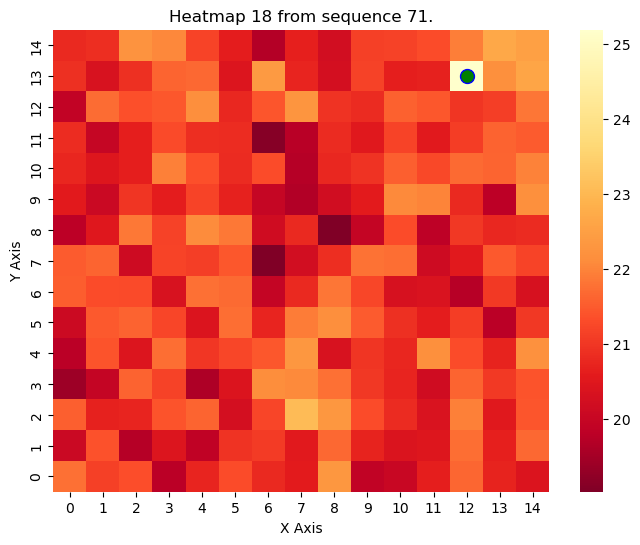

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define initial heatmap and sequence numbers
n_sequence = 71
n_heatmap = 18

# Function to update the heatmap plot
def update_heatmap(n_sequence, n_heatmap):
    clear_output(wait=True)  # Clear the previous plot
    heatmap = aug_sequences[n_sequence, n_heatmap, :, :]
    # Display the heatmap
    plt.figure(figsize=(8, 6))
    # Define the colormap to match the examples 
    cmap = plt.colormaps['YlOrRd']
    cmap = cmap.reversed()
    # Plot the heatmap
    ax = sns.heatmap(heatmap, cmap=cmap, annot=False, cbar=True)
    # Invert y axis in order to have it increasing from bottom to top
    ax.invert_yaxis()
    # Find cable with highest temperature and cable that quench
    max_T_coords = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)
    sequence_quenches = aug_quenches_list[n_sequence]
    quench_coords = []
    for q in sequence_quenches:
        if q[0] == n_heatmap:
            quench_coords.append([q[1], q[2]])
            break
    # Add blue dot for the cable with highest temperature
    plt.plot(max_T_coords[1] + 0.5, max_T_coords[0] + 0.5, 'bo', markersize=10)
    # Add green dots for the cables that quench
    if len(quench_coords) > 0:
        for coord in quench_coords:
            plt.plot(coord[0] + 0.5, coord[1] + 0.5, 'go', markersize=8)
    print('Quenches in the sequence:', aug_quenches_list[n_sequence])
    plt.title(f'Heatmap {n_heatmap} from sequence {n_sequence}.')
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.show()

    # Display buttons again after clearing the output
    display(widgets.HBox([btn_prev_heatmap, btn_next_heatmap, btn_prev_sequence, btn_next_sequence]))

# Button click handlers
def on_next_heatmap_clicked(b):
    global n_heatmap
    if n_heatmap < aug_sequences.shape[1] - 1:
        n_heatmap += 1
    update_heatmap(n_sequence, n_heatmap)

def on_prev_heatmap_clicked(b):
    global n_heatmap
    if n_heatmap > 0:
        n_heatmap -= 1
    update_heatmap(n_sequence, n_heatmap)

def on_next_sequence_clicked(b):
    global n_sequence, n_heatmap
    if n_sequence < aug_sequences.shape[0] - 1:
        n_sequence += 1
    update_heatmap(n_sequence, n_heatmap)

def on_prev_sequence_clicked(b):
    global n_sequence, n_heatmap
    if n_sequence > 0:
        n_sequence -= 1
    update_heatmap(n_sequence, n_heatmap)

# Create buttons
btn_next_heatmap = widgets.Button(description="Next Heatmap")
btn_prev_heatmap = widgets.Button(description="Previous Heatmap")
btn_next_sequence = widgets.Button(description="Next Sequence")
btn_prev_sequence = widgets.Button(description="Previous Sequence")

# Assign button click events
btn_next_heatmap.on_click(on_next_heatmap_clicked)
btn_prev_heatmap.on_click(on_prev_heatmap_clicked)
btn_next_sequence.on_click(on_next_sequence_clicked)
btn_prev_sequence.on_click(on_prev_sequence_clicked)

# Display buttons
display(widgets.HBox([btn_prev_heatmap, btn_next_heatmap, btn_prev_sequence, btn_next_sequence]))

# Initial plot
update_heatmap(n_sequence, n_heatmap)

I shuffle the dataset so that when splitting in training, validation and testing samples the transformations of each sequence can end up in different samples.

In [7]:
# Generate an array of indices and shuffle them
indices = np.arange(len(aug_sequences))
np.random.seed(42)
np.random.shuffle(indices)
# Use the shuffled indices to rearrange the sequences, labels, and quenches
aug_sequences = aug_sequences[indices]
aug_quench_labels = aug_quench_labels[indices]
aug_quenches_list = [aug_quenches_list[i] for i in indices]

I now build a CustomDataset class that will be used to load the data into PyTorch DataLoader.
The Dataloader then has the job of batching and shuffling the data during training.

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single sample and its label
        sample = self.data[idx]
        label = self.labels[idx]
        
        # Convert to PyTorch tensor and add a channel dimension
        sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        
        return sample, label


In [9]:
# Split the data into training, validation and test sets
n_sequences = aug_sequences.shape[0]
train_data = aug_sequences[:int(0.8 * n_sequences)]
train_labels = aug_quench_labels[:int(0.8 * n_sequences)]
val_data = aug_sequences[int(0.8 * n_sequences):int(0.9 * n_sequences)]
val_labels = aug_quench_labels[int(0.8 * n_sequences):int(0.9 * n_sequences)]
test_data = aug_sequences[int(0.9 * n_sequences):]
test_labels = aug_quench_labels[int(0.9 * n_sequences):]
# Compute the number of sequences that quench in the training set
n_quench_train = (train_labels == 1).sum()
# Compute the positive weight for the quench class, to be used in the loss computation
pos_weight = torch.tensor([train_labels.shape[0]/n_quench_train]).float()
print(f'{n_quench_train} sequences out of the {train_labels.shape[0]} in the training sample quench.')
print(f'The ratio between sequences that dont quench and those that do quench is {pos_weight.item():.2f}')
train_dataset = CustomDataset(train_data, train_labels)
val_dataset = CustomDataset(val_data, val_labels)
test_dataset = CustomDataset(test_data, test_labels)
# Define the batch size
batch_size = 64
# Shuffle the data during training
shuffle = True
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

1903 sequences out of the 19200 in the training sample quench.
The ratio between sequences that dont quench and those that do quench is 10.09


I now define with pytorch the CNN architecture, for which I use the 3D Convolutional layer and the fully connected Linear layer. To predict the shape of the outputs of the convolutions I use the formula

\begin{equation}
O = \frac{N-F+2P}{Stride} + 1 \, ,
\end{equation}

Where N is the dimension of the input, F is the dimension of the kernel and P is the zero-padding, which we'll keep to zero in this case. If the input of the network has shape (24, 15, 15) and I use a kernel of shape (3, 3, 3) with stride 1 and padding 1, the output has again shape (24, 15, 15). I apply this 3D convolution for 8 times and then I flatten the data and use two fully connected layers, ending with a 1D output. I omit the sigmoid function at the end because I'll use the Binary Cross Entropy (BCE) loss with Logits, which implicitly contains the sigmoid function.

In [10]:
# Define the CNN architecture
class quench_CNN(nn.Module):
    def __init__(self):
        super(quench_CNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 2, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(2, 2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(2, 1, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(24 * 15 * 15, 8)
        self.fc2 = nn.Linear(8, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.reshape(x, (x.shape[0], -1))
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x 

In [11]:
# Initialize the model, loss function, and optimizer
model = quench_CNN().to(device)
# Instantiate the BCEWithLogits loss with the weight between the two classes
pos_weight = pos_weight.to(device)
BCELogitWeighted = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# Instantiate the Adam optimizer. The setting of the starting learning rate has been done through trial and error
optimizer = optim.Adam(model.parameters(), lr=0.00008)

Before starting the training I define a function to evaluate the model, which will be used for the validation and testing sets.

In [12]:
def evaluate_model(model, dataloader, validation, pos_weight, threshold=0.5):
   # Set model to evaluation mode
    model.eval()
    # Set the validation loss to zero
    val_loss_sum = 0
    # Initialize the counters
    total_correct = 0
    total_quenches = 0
    total_quenches_correct= 0
    total_no_quenches = 0
    total_no_quenches_correct = 0
    # Initialize the output lists
    outputs_list = []
    # Initialize the labels list
    labels_list = []
    
    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in dataloader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Apply the model to the evaluation set
            outputs = model(inputs)
            outputs = outputs.squeeze()
            labels = labels.float()
            # Compute the loss if we are dealing with validation
            if validation:
                val_loss = BCELogitWeighted(outputs, labels)
                # Sum the validation losses for each batch
                val_loss_sum += val_loss.item()
            # Collect the outputs only if testing
            else:
                # Apply sigmoid to get outputs in the range (0, 1)
                outputs = F.sigmoid(outputs)
                # Get the outputs list. I reshape because the output shape is (batch_size, 1)
                outputs_list.extend(outputs.reshape(-1).tolist())
                # Get the labels list
                labels_list.extend(labels.reshape(-1).tolist())
            # Get the predicted labels by applying the threshold
            predicted = (outputs >= threshold).float()
            # Get the number of correct predictions
            total_correct += (predicted == labels).sum().item()
            total_quenches += labels.sum().item()
            total_quenches_correct += (labels * predicted).sum().item()
            total_no_quenches += labels.size(0) - labels.sum().item()
            total_no_quenches_correct += ((1 - labels) * (1 - predicted)).sum().item()
    
    # Calculate the weighted validation accuracy
    val_accuracy_quenches = total_quenches_correct/total_quenches
    val_accuracy_no_quenches = total_no_quenches_correct/total_no_quenches
    val_accuracy_weighted = (val_accuracy_quenches*pos_weight.item() + val_accuracy_no_quenches)/(1 + pos_weight.item())

    if validation:
        # Calculate average validation loss in the epoch
        avg_val_loss = val_loss_sum / len(dataloader)
        return avg_val_loss, val_accuracy_weighted
    
    else:
        # If we are testing, return the accuracy and the outputs without the loss
        return val_accuracy_weighted, outputs_list, labels_list

I've added the following randomization of the weights in order to reset the status of the model when restarting the trainings.

In [13]:
# Randomize the weights with Kaiming initialization
def randomize_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)

# Apply the randomization function to the model
model.apply(randomize_weights)

quench_CNN(
  (conv1): Conv3d(1, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(2, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(2, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=5400, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)

I now start the training loop, which should take about 15 minutes on CPU. I save the weights associated to the epoch with the best value of the validation loss and I will use them to test the trained model and evaluate it.

In [14]:
# Training loop
num_epochs = 100
# Set the best validation loss to a high value
best_val_loss = 1000
# Set the best accuracy to zero
best_accuracy = 0
# Define the path to save the best model
best_model_path = 'best_model_CNN.pth'
# Record the best epoch
best_epoch = 0
# Initialize train and validation losses lists
train_loss_vs_epoch = []
val_loss_vs_epoch = []

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    # Initialize the sum of the losses for the epoch to zero
    train_loss_sum = 0

    # Iterate over batches in the training set
    for inputs, labels in train_dataloader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the BCE loss
        outputs = outputs.squeeze()
        labels = labels.float()
        loss = BCELogitWeighted(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Sum the training losses for each batch
        train_loss_sum += loss.item()
    
    # Calculate average training loss in the epoch
    avg_train_loss = train_loss_sum / len(train_dataloader)
    train_loss_vs_epoch.append(avg_train_loss)
    
    # Define a threshold for the discrimination between quench and no quench
    threshold = 0.5
    # Evaluate the model on the validation set
    avg_val_loss, val_accuracy_weighted= evaluate_model(model, val_dataloader, validation=True, pos_weight=pos_weight, threshold=threshold)
    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss:{avg_val_loss:.4f}, Validation Accuracy: {val_accuracy_weighted:.4f}')
    # Check if the current validation loss is the best seen so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_accuracy = val_accuracy_weighted
        best_epoch = epoch + 1
        torch.save(model.state_dict(), best_model_path)
        print(f'New best model found and saved at epoch {epoch+1} with validation loss {best_val_loss:.4f}')

    # Append the validation loss for the current epoch
    val_loss_vs_epoch.append(avg_val_loss)

print('Training complete.')

Epoch [1/100], Training Loss: 1.0326, Validation Loss:1.0584, Validation Accuracy: 0.5983
New best model found and saved at epoch 1 with validation loss 1.0584
Epoch [2/100], Training Loss: 1.4719, Validation Loss:0.9245, Validation Accuracy: 0.6482
New best model found and saved at epoch 2 with validation loss 0.9245
Epoch [3/100], Training Loss: 1.0644, Validation Loss:0.8854, Validation Accuracy: 0.6431
New best model found and saved at epoch 3 with validation loss 0.8854
Epoch [4/100], Training Loss: 0.6979, Validation Loss:0.8367, Validation Accuracy: 0.6515
New best model found and saved at epoch 4 with validation loss 0.8367
Epoch [5/100], Training Loss: 1.1673, Validation Loss:0.8665, Validation Accuracy: 0.6048
Epoch [6/100], Training Loss: 1.0573, Validation Loss:0.7604, Validation Accuracy: 0.7762
New best model found and saved at epoch 6 with validation loss 0.7604
Epoch [7/100], Training Loss: 0.5225, Validation Loss:0.7633, Validation Accuracy: 0.7419
Epoch [8/100], Train

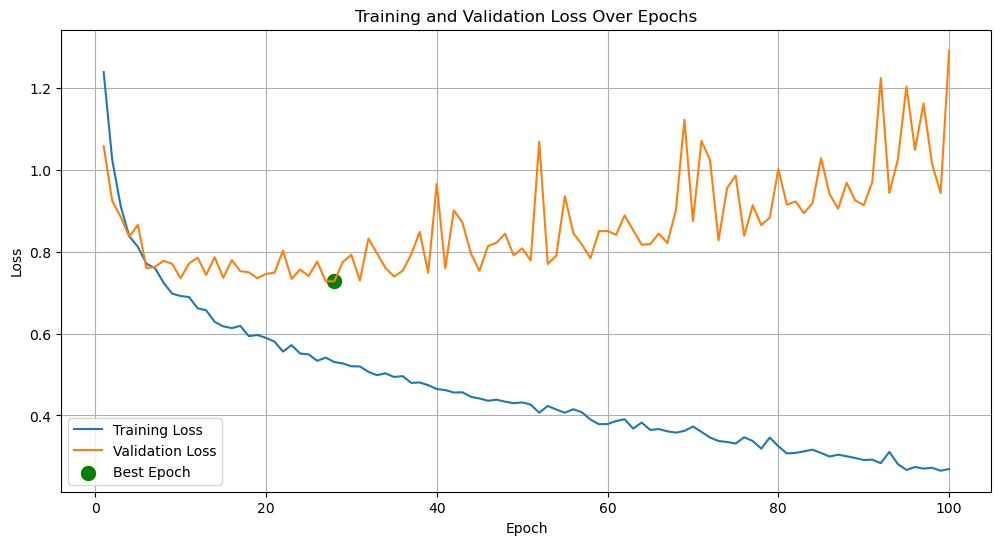

In [15]:
# Plot training and validation losses
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_vs_epoch, label='Training Loss')
plt.plot(epochs, val_loss_vs_epoch, label='Validation Loss')
# Add a green dot for the best epoch
plt.scatter(best_epoch, best_val_loss, color='green', s=100, label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

I now define a function to plot the confusion matrix from the outputs of the model.

In [16]:
# Function to plot the confusion matrix
def plot_confusion_matrix(outputs_list, labels_list, n_categories, threshold=0.5, title="Confusion Matrix"):
    # Binarize the outputs if n_categories is 2
    if n_categories == 2:
        predicted_labels = np.array(outputs_list) >= threshold
    # Otherwise use the argmax to get the predicted labels
    else:
        predicted_labels = outputs_list
    # Convert the labels list to a numpy array
    true_labels = np.array(labels_list)

    # Compute the confusion matrix
    cm = np.zeros((n_categories, n_categories), dtype=int)
    for t, p in zip(true_labels, predicted_labels):
        cm[int(t), int(p)] += 1

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    if n_categories == 2:   
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Quench", "Quench"], yticklabels=["No Quench", "Quench"])
    else:
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(n_categories), yticklabels=range(n_categories))

    plt.xlabel("Predicted Label")
    plt.ylabel("Truth Label")
    plt.title(title)
    plt.show()

I now test the trained model on the testing sample and then compute the efficiency and plot the confusion matrix.

Test Accuracy (Weighted): 0.8111


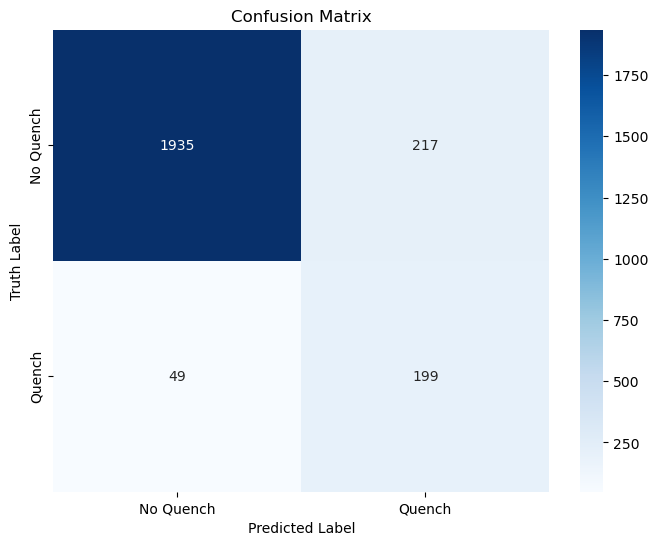

In [17]:
# Check if CUDA is available and set the map location accordingly
if torch.cuda.is_available():
    map_location = None
else:
    map_location = torch.device('cpu')
    
# Load the weights of the best model
model.load_state_dict(torch.load(best_model_path))
# Evaluate the model on the test dataset
test_accuracy_weighted, outputs_list, labels_list = evaluate_model(model, test_dataloader, False, pos_weight)

# Print the test accuracy
print(f'Test Accuracy (Weighted): {test_accuracy_weighted:.4f}')

# Define the threshold for the discrimination between quench and no quench
threshold = 0.5
plot_confusion_matrix(outputs_list, labels_list, 2, threshold)


I have noticed that the performances of the model are quite dependent on the training, but some other times the loss barely changes during the training, resulting in a very poor efficiency. I now move to the following goal, which is to count the number of quenches when at least one quench is present. I try to solve this task again with a 3D CNN, which will have as primary task the same sequence classification seen in the previous point and also an auxiliary task that will classify each image in the sequence in order to discriminate between images with quenches and images without. With the ouput of the secondary task is then possible to count the number of images that quenched. Hopefully the sequence classification task, which had quite unstable performances with the previous model, will now converge more easily. First of all let's start by looking at the distribution of the number of quenches in the dataset.

Population of each bin:[21600, 752, 504, 288, 248, 176, 112, 112, 64, 40, 40, 8, 0, 0, 56]


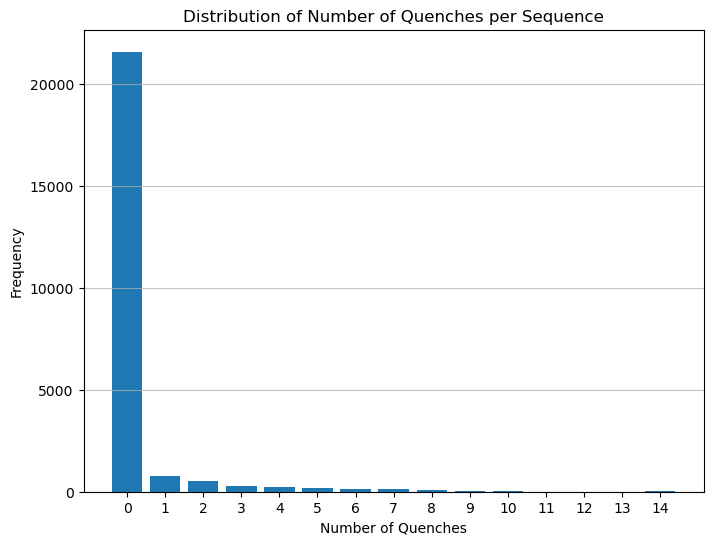

In [18]:
# Starting from the augmented list of quenches, I calculate the number of quenches per sequence
n_quenches = [len(quenches) for quenches in aug_quenches_list]
# Get the number of sequences with each number of quenches from the histogram
bin_counts, bin_edges = np.histogram(n_quenches, bins=max(n_quenches) - min(n_quenches) + 1, range=(min(n_quenches), max(n_quenches) + 1))
print(f'Population of each bin:{bin_counts.tolist()}')
# Plotting the distribution
plt.figure(figsize=(8, 6))
plt.hist(n_quenches, bins=max(n_quenches) - min(n_quenches) + 1, range=(min(n_quenches), max(n_quenches) + 1), rwidth=0.8, align='left')
plt.xlabel('Number of Quenches')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Quenches per Sequence')
plt.xticks(range(min(n_quenches), max(n_quenches) + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

I have already observed that the number of sequence that don't quench is more than 10 times the number of sequences that don't, so the previous result was expected. It wouldn't be easy to train a classifier with the weights per class that we have just seen, becasue of the predominance of the 0 class. Let's take a closer look to the distribution of the number of quenches excluding the 0 class.

Population of each bin:[752, 504, 288, 248, 176, 112, 112, 64, 40, 40, 8, 0, 0, 56]


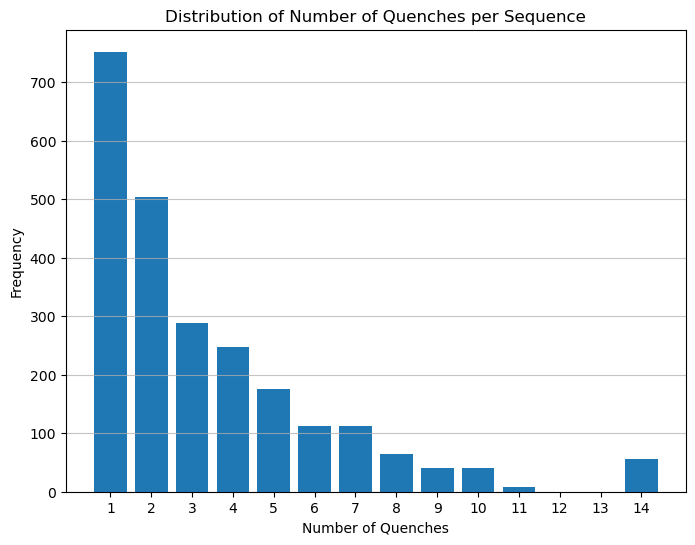

In [19]:
# I now remove the zeros from the list
n_quenches_no0 = [n for n in n_quenches if n > 0]
# Get the number of sequences with each number of quenches from the histogram
bin_counts, bin_edges = np.histogram(n_quenches_no0, bins=max(n_quenches_no0) - min(n_quenches_no0) + 1, range=(min(n_quenches_no0), max(n_quenches_no0) + 1))
print(f'Population of each bin:{bin_counts.tolist()}')
# Plotting the distribution
plt.figure(figsize=(8, 6))
plt.hist(n_quenches_no0, bins=max(n_quenches_no0) - min(n_quenches_no0) + 1, range=(min(n_quenches_no0), max(n_quenches_no0) + 1), rwidth=0.8, align='left')
plt.xlabel('Number of Quenches')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Quenches per Sequence')
plt.xticks(range(min(n_quenches_no0), max(n_quenches_no0) + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

A 14 categories classification (or 12 categories, excluding 12 and 13) would be a hard task, because of the limited training dataset and the very different frequency for each class. For this reason, I try to classify each of the 24 images in each sequence according to whether they have a cable that quenched or not. With this approach the output of the network becomes a vector of length 24 with either zeros or ones, with the goal of correctly classifying each image in the sequence. Furthermore this approach allows to use the all dataset, in order to really tackle the differencies between the quench and no quench patterns. First of all I start by creating the target outputs for the auxiliary task.

In [20]:

# For each sequence I build the target output with 0 and 1 for each image in the sequence
labels_images = []
for quenches in aug_quenches_list:
    target = [0]*24
    for quench in quenches:
        step = quench[0]
        target[step] = 1
    labels_images.append(target)
# Convert the list to a numpy array
labels_images = np.array(labels_images)
# Print the shapes of the sequences and targets
print(f'Targets shape: {labels_images.shape}')


Targets shape: (24000, 24)


I now split the image labels in training, validation and training samples and zip together the labels for the primary and secondary task, so that I can create the dataloaders associated to the new model. I also compute the number of images with a quenched cable, so that I can obtain the weight of the quench class and use it for the BCE loss of the auxiliary task.

In [21]:
# Split the image labels into training, validation and test sets
train_labels_images = labels_images[:int(0.8 * n_sequences)]
val_labels_images = labels_images[int(0.8 * n_sequences):int(0.9 * n_sequences)]
test_labels_images = labels_images[int(0.9 * n_sequences):]
# Count the number of images with quenches in the training sample
n_images_total = train_data.shape[0]*train_data.shape[1]
n_images_quench = train_labels_images.sum()
n_images_no_quench = n_images_total - n_images_quench
pos_weight_images = torch.tensor([n_images_no_quench/n_images_quench]).float()
print(f'There are {n_images_total} images in the dataset.')
print(f'There are {n_images_quench} images with quenches and {n_images_no_quench} without quenches.')
print(f'The weight for the BCE loss is {pos_weight_images.item():.2f}.')
# Combine the lables of the two tasks
train_labels_zip = list(zip(train_labels, train_labels_images))
val_labels_zip = list(zip(val_labels, val_labels_images))
test_labels_zip = list(zip(test_labels, test_labels_images))
# Define the CustomDataset object for the new model
train_dataset_images = CustomDataset(train_data, train_labels_zip)
val_dataset_images = CustomDataset(val_data, val_labels_zip)
test_dataset_images = CustomDataset(test_data, test_labels_zip)
# Define the batch size
batch_size = 64
# Shuffle the data during training
shuffle = True
# Create DataLoaders
train_dataloader_images = DataLoader(train_dataset_images, batch_size=batch_size, shuffle=shuffle)
val_dataloader_images = DataLoader(val_dataset_images, batch_size=batch_size, shuffle=shuffle)
test_dataloader_images = DataLoader(test_dataset_images, batch_size=batch_size, shuffle=shuffle)

There are 460800 images in the dataset.
There are 5522 images with quenches and 455278 without quenches.
The weight for the BCE loss is 82.45.


In [22]:
# Define the CNN architecture
class quench_images_CNN(nn.Module):
    def __init__(self):
        super(quench_images_CNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 2, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(2, 2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(2, 1, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(24 * 15 * 15, 8)
        self.fc2 = nn.Linear(8, 1)
        self.conv4 = nn.Conv3d(1, 2, kernel_size=3, stride=1, padding=(1, 0, 0))
        self.conv5 = nn.Conv3d(2, 2, kernel_size=3, stride=1, padding=(1, 0, 0))
        self.conv6 = nn.Conv3d(2, 1, kernel_size=3, stride=1, padding=(1, 0, 0))
        self.fc3 = nn.Linear(24 * 3 * 3, 24)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # Primary task
        x_1 = torch.reshape(x, (x.shape[0], -1))
        x_1 = self.fc1(x_1)
        x_1 = self.fc2(x_1)
        # Auxiliary task
        x_2 = F.relu(self.conv4(x))
        x_2 = F.relu(self.conv5(x_2))
        x_2 = F.relu(self.conv5(x_2))
        x_2 = F.relu(self.conv5(x_2))
        x_2 = F.relu(self.conv5(x_2))
        x_2 = F.relu(self.conv6(x_2))
        x_2 = torch.reshape(x_2, (x_2.shape[0], -1))
        x_2 = self.fc3(x_2)

        return x_1, x_2

In [23]:
class CustomLoss(nn.Module):
    def __init__(self, weight_task1=1.0, weight_task2=1.0, pos_weight=1.0, pos_weight_images=1.0):
        super(CustomLoss, self).__init__()
        self.weight_task1 = weight_task1
        self.weight_task2 = weight_task2
        # BCE for the sequence classification
        self.loss_task1 = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        # BCE for the image classification
        self.loss_task2 = nn.BCEWithLogitsLoss(pos_weight=pos_weight_images)

    def forward(self, outputs_task1, targets_task1, outputs_task2, targets_task2):
        # Compute the individual losses
        loss_task1 = self.loss_task1(outputs_task1, targets_task1)
        loss_task2 = self.loss_task2(outputs_task2, targets_task2)

        # Combine the losses with their respective weights
        loss = self.weight_task1 * loss_task1 + self.weight_task2 * loss_task2
        return loss

In [24]:
# Initialize the model, loss function, and optimizer
model = quench_images_CNN().to(device)
# Instantiate the loss with the weight between the two classes
pos_weight_images = pos_weight_images.to(device)
BCELogitWeighted_images = CustomLoss(weight_task1=1.0, weight_task2=8.0, pos_weight=pos_weight, pos_weight_images=pos_weight_images)
# Instantiate the Adam optimizer. The setting of the starting learning rate has been done through trial and error
optimizer = optim.Adam(model.parameters(), lr=0.0015)

I again define a function to evaluate the model either on the validation or testing samples. This time I compute the accuracy for both the primary sequence-level task and the auxiliary image-level task.

In [25]:
def evaluate_model_images(model, dataloader, validation, pos_weight, pos_weight_images, threshold=0.5):
   # Set model to evaluation mode
    model.eval()
    # Set the validation loss to zero
    val_loss_sum = 0
    # Initialize the counters
    total_correct_1 = 0
    total_quenches_1 = 0
    total_quenches_correct_1 = 0
    total_no_quenches_1 = 0
    total_no_quenches_correct_1 = 0
    total_correct_2 = 0
    total_quenches_2 = 0
    total_quenches_correct_2 = 0
    total_no_quenches_2 = 0
    total_no_quenches_correct_2 = 0
    # Initialize the output lists
    outputs_1_list = []
    outputs_2_list = []
    # Initialize the labels list
    labels_1_list = []
    labels_2_list = []
    
    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in dataloader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            # Apply the model to the evaluation set
            outputs_1, outputs_2 = model(inputs)
            outputs_1 = outputs_1.squeeze()
            outputs_2 = outputs_2.squeeze()
            labels_1 = labels[0].float() 
            labels_2 = labels[1].float()
            labels_1 = labels_1.to(device)
            labels_2 = labels_2.to(device)
            # Compute the loss if we are dealing with validation
            if validation:
                val_loss = BCELogitWeighted_images(outputs_1, labels_1, outputs_2, labels_2)
                # Sum the validation losses for each batch
                val_loss_sum += val_loss.item()
            # Collect the outputs only if testing
            else:
                # Apply sigmoid to get outputs in the range (0, 1)
                outputs_1 = F.sigmoid(outputs_1)
                outputs_2 = F.sigmoid(outputs_2)
                # Get the outputs list. I reshape because the output shape is (batch_size, 1)
                outputs_1_list.extend(outputs_1.reshape(-1).tolist())
                outputs_2_list.extend(outputs_2.reshape(-1).tolist())
                # Get the labels list
                labels_1_list.extend(labels_1.reshape(-1).tolist())
                labels_2_list.extend(labels_2.reshape(-1).tolist())
            # Get the predicted labels by applying the threshold
            predicted_1 = (outputs_1 >= threshold).float()
            predicted_2 = (outputs_2 >= threshold).float()
            # Get the number of correct predictions
            total_correct_1 += (predicted_1 == labels_1).sum().item()
            total_quenches_1 += labels_1.sum().item()
            total_quenches_correct_1 += (labels_1 * predicted_1).sum().item()
            total_no_quenches_1 += labels_1.size(0) - labels_1.sum().item()
            total_no_quenches_correct_1 += ((1 - labels_1) * (1 - predicted_1)).sum().item()
            total_correct_2 += (predicted_2 == labels_2).sum().item()
            total_quenches_2 += labels_2.sum().item()
            total_quenches_correct_2 += (labels_2 * predicted_2).sum().item()
            total_no_quenches_2 += labels_2.size(0)*labels_2.size(1) - labels_2.sum().item()
            total_no_quenches_correct_2 += ((1 - labels_2) * (1 - predicted_2)).sum().item()
    
    # Calculate the weighted validation accuracy
    val_accuracy_quenches_1 = total_quenches_correct_1/total_quenches_1
    val_accuracy_no_quenches_1 = total_no_quenches_correct_1/total_no_quenches_1
    val_accuracy_weighted_1 = (val_accuracy_quenches_1*pos_weight.item() + val_accuracy_no_quenches_1)/(1 + pos_weight.item())
    val_accuracy_quenches_2 = total_quenches_correct_2/total_quenches_2
    val_accuracy_no_quenches_2 = total_no_quenches_correct_2/total_no_quenches_2
    val_accuracy_weighted_2 = (val_accuracy_quenches_2*pos_weight_images.item() + val_accuracy_no_quenches_2)/(1 + pos_weight_images.item())

    if validation:
        # Calculate average validation loss in the epoch
        avg_val_loss = val_loss_sum / len(dataloader)
        return avg_val_loss, val_accuracy_quenches_1, val_accuracy_no_quenches_1, val_accuracy_quenches_2, val_accuracy_no_quenches_2
    
    else:
        # If we are testing, return the accuracy and the outputs without the loss
        return val_accuracy_weighted_1, val_accuracy_weighted_2, outputs_1_list, outputs_2_list, labels_1_list, labels_2_list

In [26]:
# Randomize the weights with Kaiming initialization
def randomize_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)

# Apply the randomization function to the model
model.apply(randomize_weights)

quench_images_CNN(
  (conv1): Conv3d(1, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(2, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(2, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=5400, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (conv4): Conv3d(1, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv5): Conv3d(2, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv6): Conv3d(2, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0))
  (fc3): Linear(in_features=216, out_features=24, bias=True)
)

I now start a new training with the primary and the auxiliary task. Training with 200 epochs takes about 40 minutes on CPU.

In [27]:
# Training loop
num_epochs = 200
# Set the best validation loss to a high value
best_val_loss = 1000
# Define the path to save the best model
best_model_path = 'best_model_CNN_images.pth'
# Record the best epoch
best_epoch = 0
# Initialize train and validation losses lists
train_loss_vs_epoch = []
val_loss_vs_epoch = []

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    # Initialize the sum of the losses for the epoch to zero
    train_loss_sum = 0

    # Iterate over batches in the training set
    for inputs, labels in train_dataloader_images:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs_1, outputs_2 = model(inputs)
        # Calculate the BCE loss
        outputs_1 = outputs_1.squeeze()
        outputs_2 = outputs_2.squeeze().float()
        labels_1 = labels[0].float() 
        labels_2 = labels[1].float()
        labels_1 = labels_1.to(device)
        labels_2 = labels_2.to(device)
        loss = BCELogitWeighted_images(outputs_1, labels_1, outputs_2, labels_2)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Sum the training losses for each batch
        train_loss_sum += loss.item()
    
    # Calculate average training loss in the epoch
    avg_train_loss = train_loss_sum / len(train_dataloader_images)
    train_loss_vs_epoch.append(avg_train_loss)
    
    # Define a threshold for the discrimination between quench and no quench
    threshold = 0.5
    # Evaluate the model on the validation set
    avg_val_loss, acc_quench_1, acc_no_quench_1, acc_quench_2, acc_no_quench_2 = evaluate_model_images(
        model, val_dataloader_images, True, pos_weight, pos_weight_images, threshold)
    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss:{avg_val_loss:.4f}')
    print(f'Primary Task: validation accuracy for quenches is {acc_quench_1:.4f}, for no quench is {acc_no_quench_1:.4f}')
    print(f'Auxiliary Task: validation accuracy for quenches is {acc_quench_2:.4f}, for no quench is {acc_no_quench_2:.4f}')
    # Check if the current validation loss is the best seen so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), best_model_path)
        print(f'New best model found and saved at epoch {epoch+1} with validation loss {best_val_loss:.4f}')

    # Append the validation loss for the current epoch
    val_loss_vs_epoch.append(avg_val_loss)

print('Training complete.')

Epoch [1/200], Training Loss: 10.8409, Validation Loss:10.0696
Primary Task: validation accuracy for quenches is 0.0843, for no quench is 1.0000
Auxiliary Task: validation accuracy for quenches is 0.1513, for no quench is 0.9166
New best model found and saved at epoch 1 with validation loss 10.0696
Epoch [2/200], Training Loss: 8.2038, Validation Loss:9.8607
Primary Task: validation accuracy for quenches is 0.2771, for no quench is 0.9716
Auxiliary Task: validation accuracy for quenches is 0.3083, for no quench is 0.8335
New best model found and saved at epoch 2 with validation loss 9.8607
Epoch [3/200], Training Loss: 8.2892, Validation Loss:9.6822
Primary Task: validation accuracy for quenches is 0.4297, for no quench is 0.9605
Auxiliary Task: validation accuracy for quenches is 0.6082, for no quench is 0.6486
New best model found and saved at epoch 3 with validation loss 9.6822
Epoch [4/200], Training Loss: 4.1241, Validation Loss:3.8956
Primary Task: validation accuracy for quenche

Epoch [5/200], Training Loss: 1.3218, Validation Loss:1.8338
Primary Task: validation accuracy for quenches is 0.9960, for no quench is 1.0000
Auxiliary Task: validation accuracy for quenches is 0.9646, for no quench is 0.9644
New best model found and saved at epoch 5 with validation loss 1.8338
Epoch [6/200], Training Loss: 1.0158, Validation Loss:1.6199
Primary Task: validation accuracy for quenches is 1.0000, for no quench is 1.0000
Auxiliary Task: validation accuracy for quenches is 0.9802, for no quench is 0.9661
New best model found and saved at epoch 6 with validation loss 1.6199
Epoch [7/200], Training Loss: 1.5554, Validation Loss:1.5444
Primary Task: validation accuracy for quenches is 0.9960, for no quench is 1.0000
Auxiliary Task: validation accuracy for quenches is 0.9901, for no quench is 0.9648
New best model found and saved at epoch 7 with validation loss 1.5444
Epoch [8/200], Training Loss: 1.7702, Validation Loss:1.3860
Primary Task: validation accuracy for quenches i

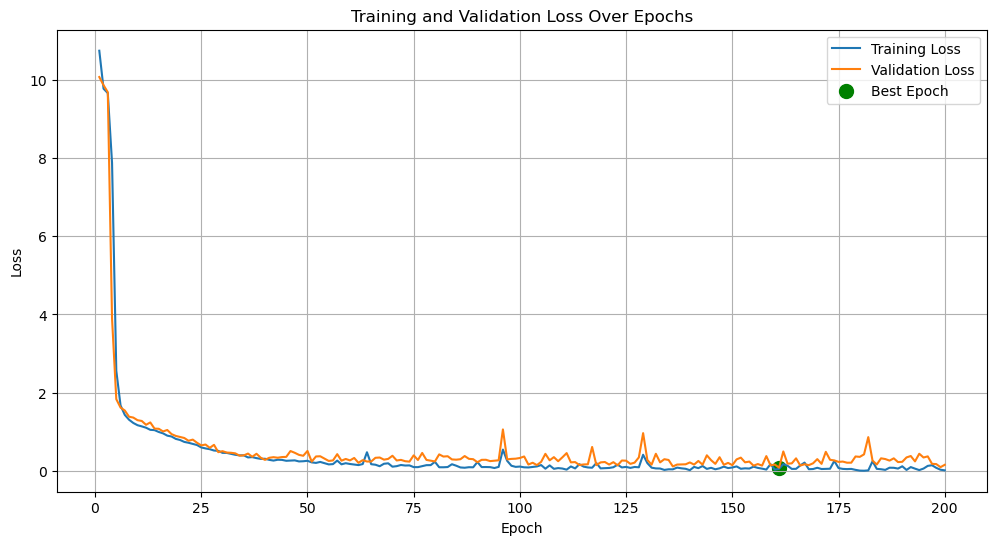

In [28]:
# Plot training and validation losses
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_vs_epoch, label='Training Loss')
plt.plot(epochs, val_loss_vs_epoch, label='Validation Loss')
# Add a green dot for the best epoch
plt.scatter(best_epoch, best_val_loss, color='green', s=100, label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

I now test the trained model on the testing sample. I then compute the efficiency and plot the confusion matrix for both the primary and the auxiliary task.

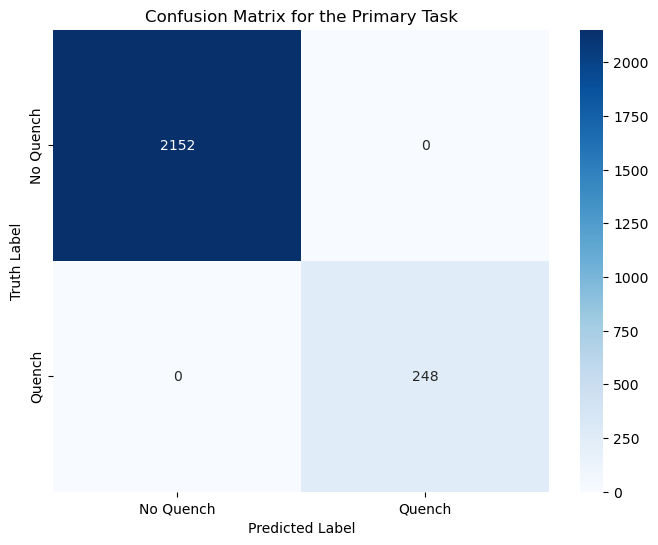

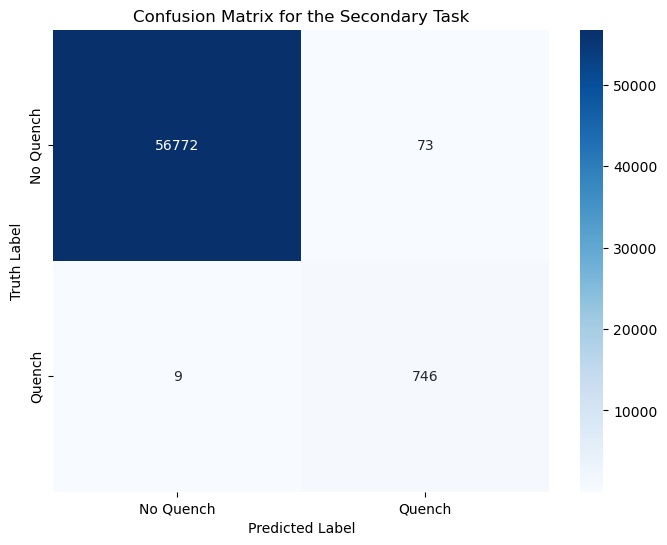

In [29]:
# Check if CUDA is available and set the map location accordingly
if torch.cuda.is_available():
    map_location = None
else:
    map_location = torch.device('cpu')
    
# Load the weights of the best model
model.load_state_dict(torch.load(best_model_path))
# Evaluate the model on the test dataset
test_acc_weighted_1, test_acc_weighted_2, outputs_list_1, outputs_list_2, labels_list_1, labels_list_2 = evaluate_model_images(
    model, test_dataloader_images, False, pos_weight, pos_weight_images)

# Print the test accuracy
#print(f'Test Accuracy (Weighted) for the primary task: {test_acc_weighted_1:.4f}')
# Define the threshold for the discrimination between quench and no quench
threshold_1 = 0.5
# Plot the confusion matrix for the primary task
title_1 = 'Confusion Matrix for the Primary Task'
plot_confusion_matrix(outputs_list_1, labels_list_1, 2, threshold_1, title_1)
# Print the test accuracy
#print(f'Test Accuracy (Weighted) for the auxiliary task: {test_acc_weighted_2:.4f}')
# Define the threshold for the discrimination between quench and no quench
threshold_2 = 0.5
# Plot the confusion matrix for the auxiliary task
title_2 = 'Confusion Matrix for the Secondary Task'

plot_confusion_matrix(outputs_list_2, labels_list_2, 2, threshold_2, title_2)


I observe that the introduction of the auxiliary task for the quenching image in the sequence has stabilized the primary task and helped increase the accuracy of the sequence classification. I now want to count the predicted number of quenches for each sequence, and confront this result with the true values. To do so I need to sum the elements in the output of the secondary task for each sequence. In the following I also plot the confusion matrix relative to the number of quenches.

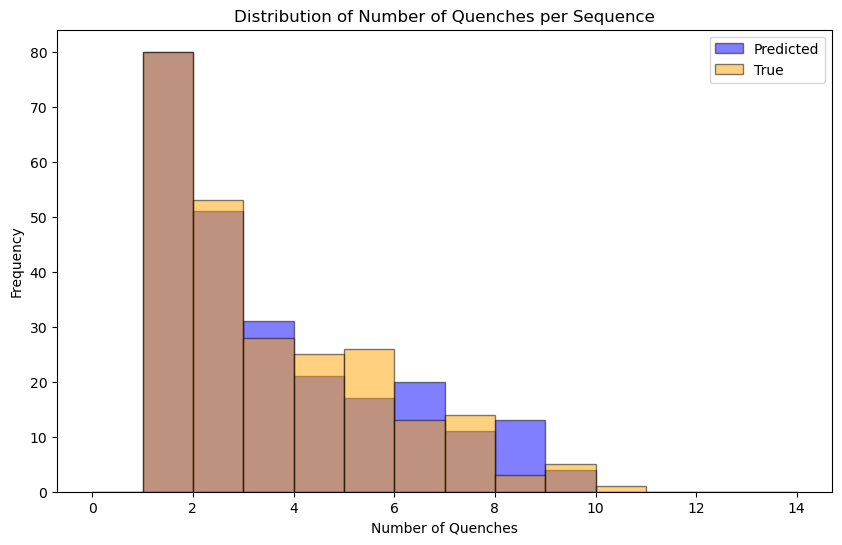

In [30]:
# Convert the lists to numpy arrays and reshape to get 24 image labels per sequence
outputs_2_array = np.array(outputs_list_2).reshape(-1, 24)
labels_2_array = np.array(labels_list_2).reshape(-1, 24)
# Sum the labels to get the total number of quenches per sequence
outputs_2_sum = outputs_2_array.sum(axis=1)
labels_2_sum = labels_2_array.sum(axis=1)
# Remove sequences with zero quenches
nonzero_indices = (labels_2_sum > 0)
outputs_2_sum = outputs_2_sum[nonzero_indices]
labels_2_sum = labels_2_sum[nonzero_indices]

# Plot the distribution of the number of quenches in the sequences
plt.figure(figsize=(10, 6))
# Histograms for predicted and true quenches on the same plot
plt.hist(outputs_2_sum, bins=range(0, 15), alpha=0.5, color='blue', edgecolor='black', label='Predicted')
plt.hist(labels_2_sum, bins=range(0, 15), alpha=0.5, color='orange', edgecolor='black', label='True')
plt.title('Distribution of Number of Quenches per Sequence')
plt.xlabel('Number of Quenches')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


Finally, to have a better understanding of the performance of the secondary task, I now plot the confusion matrix for the number of quenches.

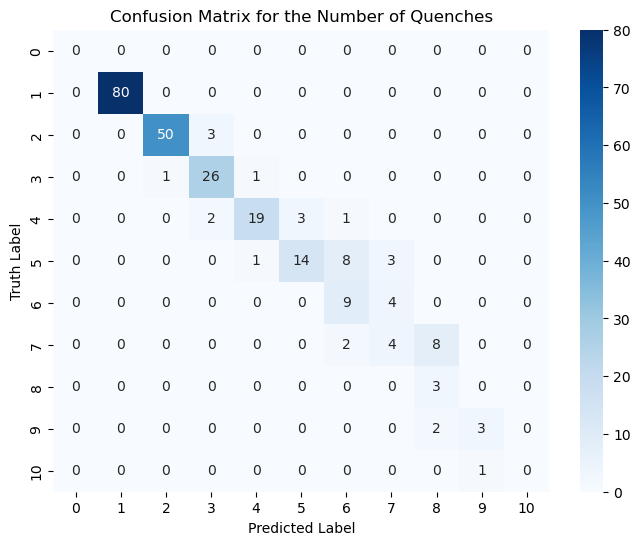

In [31]:
max_number = int(max(np.max(labels_2_sum), np.max(outputs_2_sum)))
plot_confusion_matrix(outputs_2_sum, labels_2_sum, max_number + 1, threshold=0.5, title="Confusion Matrix for the Number of Quenches")

The prediction of the total number of quenches is quite accurate and when the prediction of the number of quenches is wrong, the prediction is most of the time off by 1 quench and only rarly by 2. From this we can be satisfied with the performance of the auxiliary task, considering the simple architecture that has been used.